# Seq2Seq Q&A Chatbot 구현 실습

### 데이터 취득

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 데이터 전처리

In [10]:
# 학습용 텍스트 파일 생성 (Q + A)
df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]
df


,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [11]:
# 질문과 답변을 각각 배열로 저장
all_texts = []
Q_texts = []
A_texts = []

for Q, A in df.values:
    Q_texts.append(Q)
    A_texts.append(A)

all_texts = Q_texts + A_texts 

In [12]:
# 학습용 텍스트 파일 생성 (Q + A)
with open('chatbot_qna.txt', 'w', encoding='utf-8') as f:
    for text in all_texts:
        f.write(text + '\n')

##### 토커나이저 학습 (sentencepiece 활용)
- 접두사, 접미사 처리

In [13]:
import sentencepiece as spm

input_text = 'chatbot_qna.txt'
pad_id = 0
vocab_size = 5000
prefix = 'chatbot_qna'
bos_id = 1  # <sos>
eos_id = 2  # <eos>
unk_id = 3  # <oov>

cmd = f'--input={input_text} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id} --model_prefix={prefix} --vocab_size={vocab_size}'

spm.SentencePieceTrainer.Train(cmd)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=chatbot_qna.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=chatbot_qna --vocab_size=5000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: chatbot_qna.txt
  input_format: 
  model_prefix: chatbot_qna
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk

In [14]:
sp = spm.SentencePieceProcessor()
sp.load(f'{prefix}.model')

True

In [20]:
vocab_size = sp.get_piece_size()
# print(vocab_size)
tokens = sp.encode_as_pieces('오늘은 즐거운 수요일')
print(tokens)
seq = sp.encode_as_ids('오늘은 즐거운 수요일')
print(seq)
text = sp.decode_pieces(tokens)
print(text)
text = sp.decode_ids(seq)
print(text)

['▁오늘', '은', '▁즐거', '운', '▁수', '요', '일']
[78, 15, 850, 170, 20, 6, 76]
오늘은 즐거운 수요일
오늘은 즐거운 수요일


##### 학습용 데이터 Q_input, A_input, A_target 생성

In [22]:
sp.set_encode_extra_options(':')
Q_inputs = [sp.encode_as_ids(q) for q in Q_texts]
Q_inputs[:5]

[[4228, 299, 5, 4826, 72],
 [291, 14, 933, 674, 1735],
 [277, 1280, 2810, 76, 2964, 94],
 [277, 1280, 2810, 76, 667, 2964, 94],
 [5, 4549, 4549, 3, 1395, 64]]

In [23]:
sp.set_encode_extra_options('bos:')
A_inputs = [sp.encode_as_ids(a) for a in A_texts]
A_inputs[:5]

[[1, 282, 7, 113, 82, 23, 4],
 [1, 1459, 5, 3717, 4],
 [1, 293, 15, 385, 39, 207, 4],
 [1, 293, 15, 385, 39, 207, 4],
 [1, 208, 970, 10, 2434, 3090, 173, 14, 40, 4]]

In [24]:
sp.set_encode_extra_options(':eos')
A_targets = [sp.encode_as_ids(a) for a in A_texts]
A_targets[:5]


[[282, 7, 113, 82, 23, 4, 2],
 [1459, 5, 3717, 4, 2],
 [293, 15, 385, 39, 207, 4, 2],
 [293, 15, 385, 39, 207, 4, 2],
 [208, 970, 10, 2434, 3090, 173, 14, 40, 4, 2]]

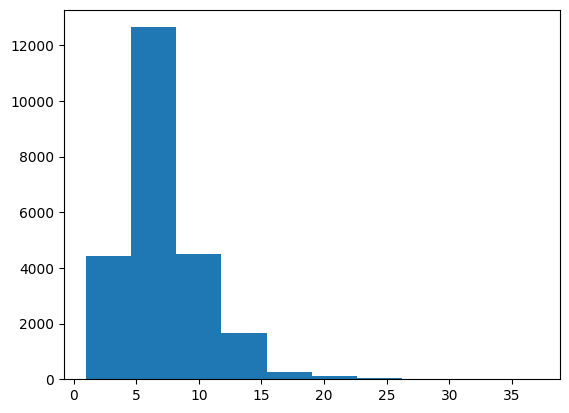

In [27]:
# 최대 길이 확인
Q_max_len = max([len(seq) for seq in Q_inputs])
A_max_len = max([len(seq) for seq in A_inputs])
Q_max_len, A_max_len

plt.hist([len(seq) for seq in Q_inputs + A_inputs])
plt.show()

In [28]:
MAX_LEN = 30

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Q_inputs_padded = pad_sequences(Q_inputs, maxlen=MAX_LEN, padding='pre', truncating='post')
A_inputs_padded = pad_sequences(A_inputs, maxlen=MAX_LEN, padding='post', truncating='post')
A_targets_padded = pad_sequences(A_targets, maxlen=MAX_LEN, padding='post', truncating='post')

### 모델 생성

##### 인코더 생성

In [35]:
from tensorflow.keras import layers, models

EMBEDDING_DIM = 100
LATENT_DIM = 128

encoder_input = layers.Input(shape=(MAX_LEN,))
q_embedding = layers.Embedding(vocab_size + 1, EMBEDDING_DIM)
x = q_embedding(encoder_input)
_, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_input, outputs=encoder_states)

##### 디코더 (teacher-forcing 모델) 생성

In [37]:
decoder_input = layers.Input(shape=[MAX_LEN,])
a_embedding = layers.Embedding(vocab_size + 1, EMBEDDING_DIM)
x = a_embedding(decoder_input)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_dense = layers.Dense(vocab_size + 1, activation='softmax')
decoder_output = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)

### 모델 학습

##### 학습

In [40]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

decoder_teacher_forcing_model.fit(
    [Q_inputs_padded, A_inputs_padded],
    A_targets_padded,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 51s 322ms/step - accuracy: 0.7655 - loss: 1.5719 - val_accuracy: 0.7618 - val_loss: 1.7010
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 50s 340ms/step - accuracy: 0.8050 - loss: 1.3304 - val_accuracy: 0.7667 - val_loss: 1.6528
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 48s 326ms/step - accuracy: 0.8077 - loss: 1.2806 - val_accuracy: 0.7700 - val_loss: 1.6279
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 48s 328ms/step - accuracy: 0.8122 - loss: 1.2360 - val_accuracy: 0.7732 - val_loss: 1.6091
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - accuracy: 0.8146 - loss: 1.2057 - val_accuracy: 0.7765 - val_loss: 1.5915
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.8180 - loss: 1.1718 - val_accuracy: 0.7797 - val_loss: 1.5727
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.8215 - loss: 1.1410 - val_accuracy: 0.7824 - val_loss: 1.5540
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 48s 325ms/step - accuracy: 0.8277 - loss: 1

##### 디코더 (추론 모델) 생성

In [41]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_state_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))
x = a_embedding(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_state_inputs)
decoder_states = [h, c]

output = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_state_inputs,
    outputs=[output] + decoder_states    
)

### 추론 함수
- 추론 함수 생성 및 테스트

In [ ]:
def qna_chatbot(input_seq, temperature=1.0):
    # 인코더
    states_value = encoder_model.predict(input_seq)
    
    # 디코더
    target_seq = np.zeros((1, 1))
    bos_id = sp.bos_id()
    eos_id = sp.eos_id()
    target_seq[0, 0] = bos_id

    output_ids = []

    for _ in range(MAX_LEN):
        output, h, c = decoder_inference_model.predict([target_seq] + states_value)

        pred_proba = output[0, 0, :]
        
        pred_proba = np.log(pred_proba + 1e-10) / temperature
        pred_proba = np.exp(pred_proba) / np.sum(np.exp(pred_proba))  # 소프트맥스 
        pred_id = np.random.choice(len(pred_proba), p=pred_proba)

        if pred_id == eos_id:
            break

        if pred_id > 0:
            output_ids.append(int(pred_id))

        target_seq[0, 0] = pred_id
        states_value = [h, c]

    return sp.decode_ids(output_ids)

##### 간단한 챗봇 구현

In [45]:
while True:
    text = input('질문: ')

    if text.lower() == 'exit':
        break

    input_seq = sp.encode_as_ids(text)
    input_seq = pad_sequences([input_seq], maxlen=MAX_LEN, padding='pre', truncating='post')
    output = qna_chatbot(input_seq)
    print('답변:', output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
답변: 후회해도 그래요.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
답변: 지금은 우세요.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
답변: 용기를 팍팍 내요!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━